
# Exercise 1.1
## Classification of MNIST digits with a fully-connected neural network

In this exercise we will classify [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) using a fully-connected neural network

We start by importing the modules that we need

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We check that we have a GPU available

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


The MNIST dataset is a built-in dataset in PyTorch (it is a very common dataset to test algorithms on). 

We import it, and set our minibatch size

In [ ]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


First, we plot the images to get an idea of what data we're working with. MNIST images are $28\times28$ images of handwritten digits (0-9)

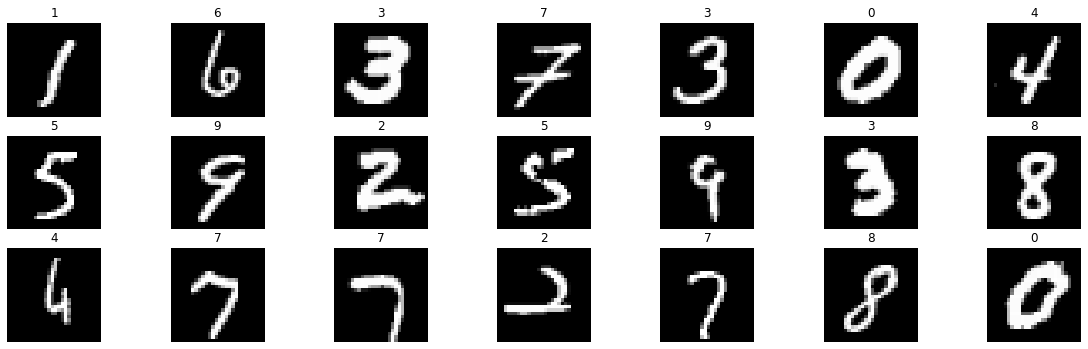

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

You should implement a fully-connected network to classify the digits. It should contain 1 hidden layer with 100 units. Don't forget the ReLU activation function after the hidden layer. 

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300,100),
            nn.ReLU()
            )
        
        self.fully_connected2 = nn.Sequential(
            nn.Linear(100,10),
            nn.Softmax(dim = 1)
            )
        

    def forward(self, x):
      #reshaping x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0),-1)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x

We instantiate a copy of our network and transfer it to the GPU if it's available

In [ ]:
model = Network()
model.to(device)
#Initialize the optimer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

We train the network for five epochs

In [ ]:
num_epochs = 5

train_loss = []
train_acc_array = []
test_acc_array = []
for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    train_loss.append(loss.sum().item())
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    train_acc_array.append(train_acc)
    test_acc_array.append(test_acc)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))


Accuracy train: 100.0%	 test: 98.1%



Accuracy train: 100.0%	 test: 98.2%



Accuracy train: 100.0%	 test: 98.1%



Accuracy train: 100.0%	 test: 98.2%



Accuracy train: 100.0%	 test: 98.1%



You should now have a model that has about 96% accuracy on the test set.
Try to get an even better accuracy. You can
* Change the number of hidden layers
* Change the number of units in the hidden layers
* Try changing the learning rate by factors of 10. What happens if it is too high or too low?
* Try using sigmoid instead of ReLU activation. What happens?

How large accuracy can you get?

Try showing the classification output (probabilities) from the model alongside the ground truth.

* Which are classified correctly/incorrectly? 
* If it's incorrect, what is the second most likely class?
* Do the misclassifications you see make sense? Why/why not?

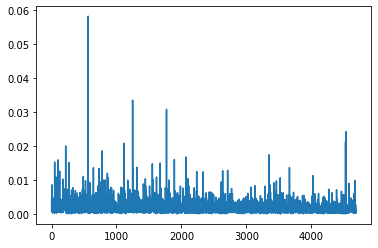

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)


predicted number: 2, Target number: 1
Accuracy of prediction: 57.70228576660156%
predicted number: 6, Target number: 4
Accuracy of prediction: 75.32456970214844%
predicted number: 9, Target number: 5
Accuracy of prediction: 90.19588470458984%


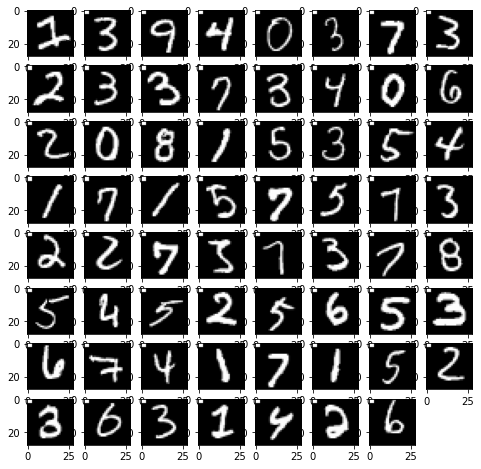

In [ ]:
import random
num_images_to_test = 10
images = []
random_batch = random.randint(0, len(test_loader)-1)
i = 0
for data, target in test_loader:
    if random_batch == i:
      data = data.to(device)
      
      with torch.no_grad():
        output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
      images = data.cpu().numpy()
      break
    i += 1

fig=plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for i in range(1, images.shape[0]):
    target_image = target[i]
    predicted_image = predicted[i]
    correct = (target_image==predicted_image).sum().item()
    if not correct:
      print(f'predicted number: {predicted_image}, Target number: {target_image}')
      print(f'Accuracy of prediction: {output[i].max()*100}%')
    img = images[i].reshape(28, 28)
    if correct:
      img[0:3, 0:3] = 1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()